# 0.0. Imports

In [1]:
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

## 0.1. Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2. Load dataset

In [4]:
# Connect database
import pandas   as pd
import psycopg2 as pg

In [5]:
HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
PORT = '5432'
DATABASE = 'comunidadedsdb'
USER = 'member'
PASSWORD ='cdspa'

conn = pg.connect(host=HOST,
                  database=DATABASE,
                  port=PORT,
                  user=USER,
                  password=PASSWORD)

query = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                       INNER JOIN pa004.insurance i ON (u.id = i.id)
"""

data = pd.read_sql(query, conn)

In [6]:
data.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [7]:
data.to_csv('../data/raw/train.csv', index=False)

In [8]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [9]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,id.1,driving_license,vehicle_age,vehicle_damage,id.2,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [10]:
df_raw = df_raw.drop(df_raw.columns[[5, 9]], axis = 1)
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 1.0. Data Description

In [11]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [12]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [13]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [14]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [15]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1. Numerical Attributes

In [17]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.5.2. Categorical Attributes

In [18]:
cat_attributes

,gender,vehicle_age,vehicle_damage
0,Male,< 1 Year,Yes
1,Female,1-2 Year,No
2,Female,< 1 Year,No
3,Female,< 1 Year,No
4,Male,1-2 Year,Yes
...,...,...,...
381104,Male,< 1 Year,No
381105,Female,1-2 Year,Yes
381106,Female,1-2 Year,No
381107,Female,1-2 Year,Yes


In [19]:
df1.to_csv('../data/interim/df1.csv', index=False)

# 2.0. Feature Engineering

In [20]:
df2 = pd.read_csv('../data/interim/df1.csv')

In [21]:
# Vehicle Damage Number - Binary Categorical -> Binary Numeric
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 
                                                 1 if x == 'Yes' else
                                                 0)

# Vehicle Age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x:
                            'over_2_years' if x == '> 2 Years' else
                        'between_1_2_year' if x == '1-2 Year'  else
                            'below_1_year')

In [22]:
df2.to_csv('../data/interim/df2.csv', index=False)

# 3.0. Data Filtering

In [23]:
df3 = pd.read_csv('../data/interim/df2.csv')

In [24]:
df3.to_csv('../data/interim/df3.csv', index=False)

# 4.0. Exploratoria Data Analysis

In [25]:
df4 = pd.read_csv('../data/interim/df3.csv')

## 4.1. Univariate Analysis

We need to find variates that are separate in relation to response variable, so these variables helps the algorithm to classificate the data in a better way.

If we have variables that merge some behavior of the features, these variables will not help the algorithm.

In [26]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

### 4.1.1 Age

<AxesSubplot:xlabel='response', ylabel='age'>

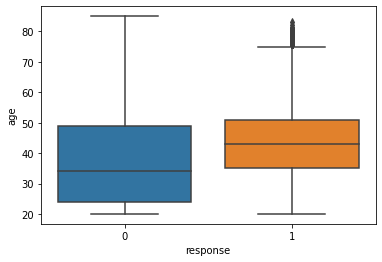

In [27]:
sns.boxplot(x = 'response', y = 'age', data = df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

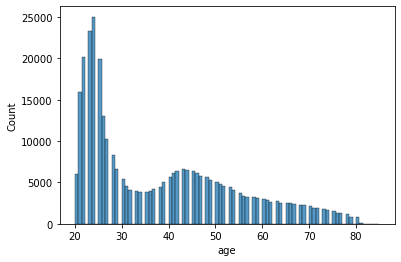

In [28]:
num_no = df4.loc[df4['response'] == 0, 'age']
sns.histplot(num_no)

<AxesSubplot:xlabel='age', ylabel='Count'>

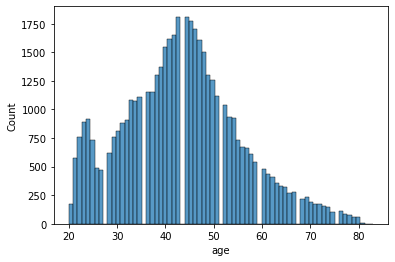

In [29]:
num_yes = df4.loc[df4['response'] == 1, 'age']
sns.histplot(num_yes)

### 4.1.2 Gender

<AxesSubplot:xlabel='response', ylabel='gender'>

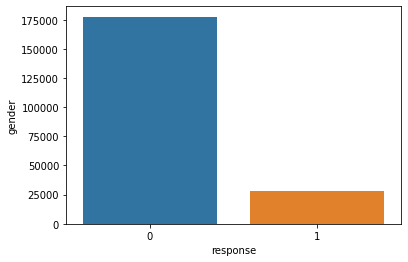

In [30]:
gend_m = df4[df4['gender'] == 'Male']
gend_m = gend_m[['gender', 'response']].groupby('response').count().reset_index()
sns.barplot(x = 'response', y = 'gender', data = gend_m)

<AxesSubplot:xlabel='response', ylabel='gender'>

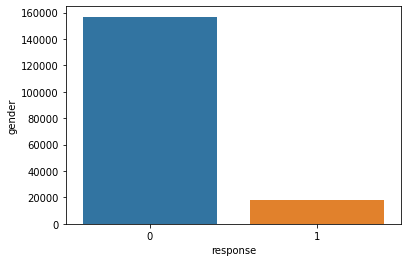

In [31]:
gend_f = df4[df4['gender'] == 'Female']
gend_f = gend_f[['gender', 'response']].groupby('response').count().reset_index()
sns.barplot(x = 'response', y = 'gender', data = gend_f)

### 4.1.3 Region Code

In [32]:
df4['region_code'].unique()

array([11., 15., 35.,  8., 28., 39., 29., 30., 25., 22., 36.,  0., 26.,
        6., 48., 47., 33., 41., 46., 43.,  2., 37., 40.,  4., 10., 18.,
        9.,  3., 50., 32., 24., 27., 34., 21., 45., 12.,  5., 49., 14.,
       16., 13., 31., 23.,  1., 42.,  7., 17., 44., 19., 38., 20., 52.,
       51.])

<AxesSubplot:xlabel='region_code', ylabel='id'>

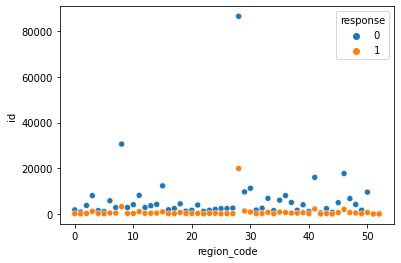

In [33]:
reg_cod = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = reg_cod)

# region_code x vehicle_damage x previously_insured

### 4.1.4 Policy Sales Channel

For 2nd cycle implement stacked percentage bar chart

In [34]:
pol_sal_no = df4[df4['response'] == 0]
pol_sal_no = pol_sal_no[['policy_sales_channel', 'response']].groupby('policy_sales_channel').count()
pol_sal_no.head()

,response
policy_sales_channel,
1.0,1039
2.0,3
3.0,364
4.0,407
6.0,3


In [35]:
pol_sal_yes = df4[df4['response'] == 1]
pol_sal_yes = pol_sal_yes[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum()
pol_sal_yes.head()

,response
policy_sales_channel,
1.0,35
2.0,1
3.0,159
4.0,102
7.0,182


In [36]:
pol_sal = pd.merge(pol_sal_no, pol_sal_yes, how = 'inner', on = 'policy_sales_channel')

pol_sal = pol_sal.rename(columns = {'policy_sales_channel': 'policy_sales_channel', 'response_x':'response_0', 'response_y':'response_1'})

pol_sal['total_responses'] = df4[['id', 'policy_sales_channel']].groupby('policy_sales_channel').size()

pol_sal['perc_response_1'] = (pol_sal['response_1']/pol_sal['total_responses'])*100
pol_sal = pol_sal.reset_index()
pol_sal.head()

,policy_sales_channel,response_0,response_1,total_responses,perc_response_1
0,1.0,1039,35,1074,3.258845
1,2.0,3,1,4,25.000000
2,3.0,364,159,523,30.401530
3,4.0,407,102,509,20.039293
4,7.0,1416,182,1598,11.389237


In [37]:
pol_sal_1000 = pol_sal[pol_sal['total_responses'] >= 1000]
pol_sal_1000.sort_values(['perc_response_1'], ascending=False)

,policy_sales_channel,response_0,response_1,total_responses,perc_response_1
112,155.0,839,395,1234,32.009724
118,163.0,2013,880,2893,30.418251
114,157.0,4890,1794,6684,26.840215
111,154.0,4519,1474,5993,24.595361
113,156.0,8364,2297,10661,21.545821
22,25.0,1479,369,1848,19.967532
23,26.0,63809,15891,79700,19.938519
90,124.0,59999,13996,73995,18.914792
89,122.0,8210,1720,9930,17.321249
45,55.0,1075,189,1264,14.952532


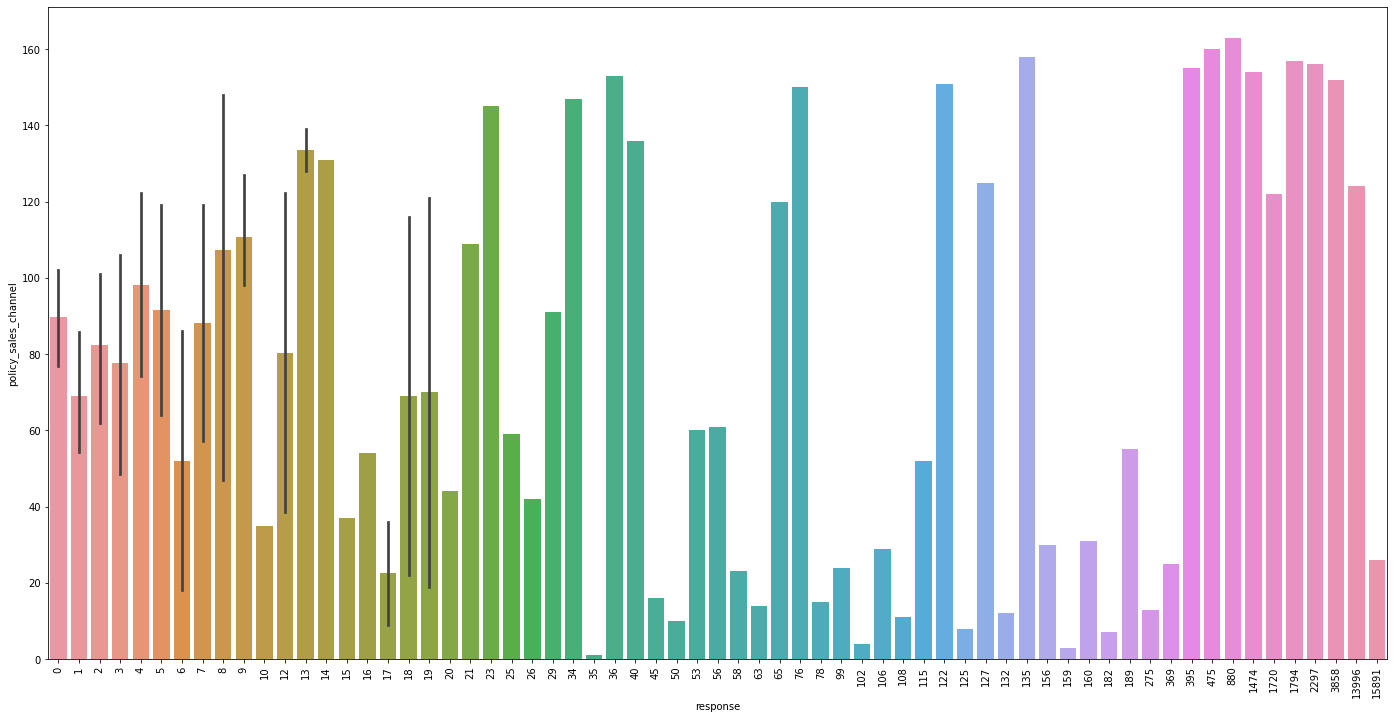

In [38]:
plt.figure(figsize = (24, 12))
pol_sal = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x = 'response', y = 'policy_sales_channel', data = pol_sal)
plt.xticks(rotation=90);

### 4.1.5 Driving License

In [39]:
df4[['driving_license', 'response']].head()

,driving_license,response
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [40]:
df4['driving_license'].unique()

array([1, 0])

<AxesSubplot:xlabel='response', ylabel='driving_license'>

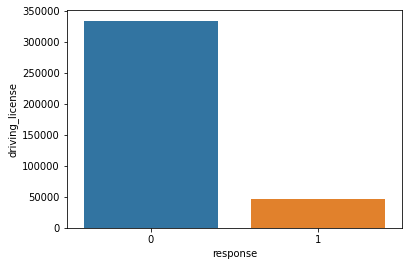

In [41]:
driv_lic = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x = 'response', y = 'driving_license', data = driv_lic)

In [42]:
driv_lic['driving_license_perc'] = driv_lic['driving_license']/driv_lic['driving_license'].sum()
driv_lic

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


### 4.1.6 Vehicle Age

In [43]:
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


### 4.1.7 Vehicle Damage

<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

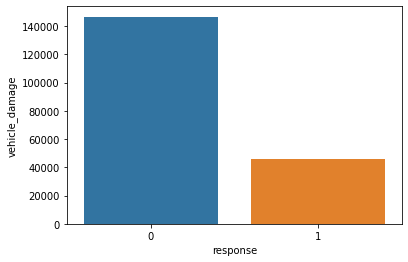

In [44]:
vehi_dam = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x = 'response', y = 'vehicle_damage', data = vehi_dam)

In [45]:
vehi_dam

,response,vehicle_damage
0,0,146685
1,1,45728


### 4.1.8 Previously Insured

It need to be careful because this feature can tell to the model that people that already have vehicle insurance will not be interested in the offer of the company, that is not true. 

This would be a data lackage.

In [46]:
df4['previously_insured'].unique()

array([0, 1])

In [47]:
# Contingency table
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


<AxesSubplot:xlabel='previously_insured', ylabel='id'>

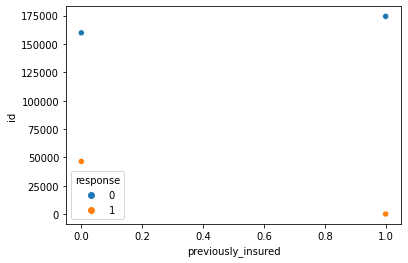

In [48]:
pre_ins = df4[['id', 'previously_insured', 'response']].groupby(['previously_insured', 'response']).count().reset_index()

sns.scatterplot(x = 'previously_insured', y = 'id', hue = 'response', data = pre_ins)

In [49]:
df4['response'].unique()

array([0, 1])

### 4.1.9 Annual Premium

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

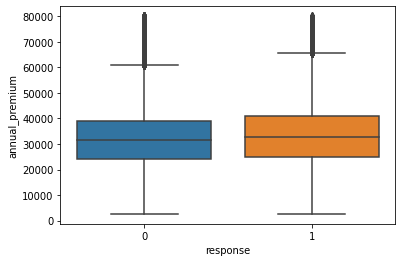

In [50]:
ann_pre = df4[df4['annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = ann_pre)

In [51]:
df = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

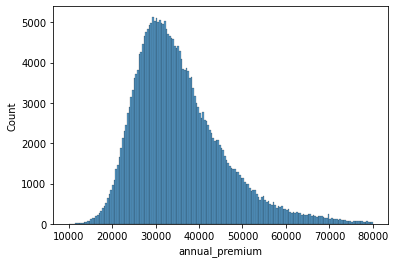

In [52]:
num_no = df.loc[df['response'] == 0, 'annual_premium']
sns.histplot(num_no)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

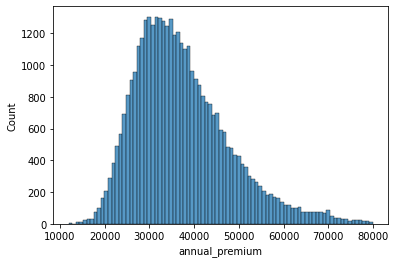

In [53]:
num_yes = df.loc[df['response'] == 1, 'annual_premium']
sns.histplot(num_yes)

### 4.1.10 Vintage

<AxesSubplot:xlabel='response', ylabel='vintage'>

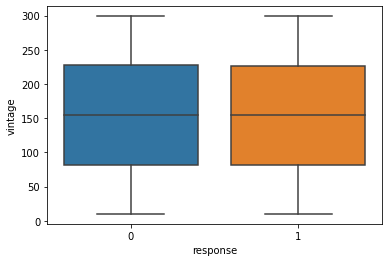

In [54]:
sns.boxplot(x = 'response', y = 'vintage', data = df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

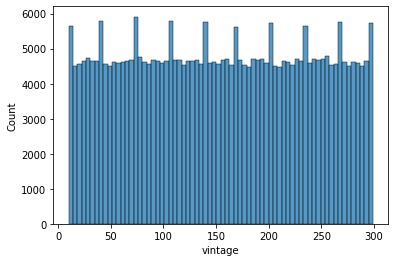

In [55]:
vint_no = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(vint_no)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

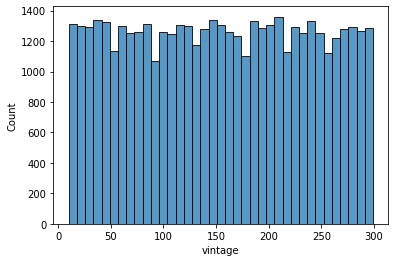

In [56]:
vint_yes = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(vint_yes)

## 4.2 Bivariate Analysis

In [57]:
df4.to_csv('../data/interim/df4.csv', index=False)

# 5.0 Data Preparation

In [58]:
df5 = pd.read_csv('../data/interim/df4.csv')

In [59]:
df5.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [60]:
# splitting the train dataset in train and validation
X = df5.drop('response', axis=1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [61]:
df5[['annual_premium']].values

array([[31497.],
       [34538.],
       [27756.],
       ...,
       [28698.],
       [43387.],
       [ 2630.]])

In [62]:
# annual_premium -> to be already like a normal distribution, in the first cycle the outliers will be maintained
ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
df5['annual_premium']

175310    0.054083
126941    0.230595
124169   -0.163060
103028    0.139176
309005   -0.160681
            ...   
241478   -1.621478
276415    0.271748
25970    -0.108383
32361     0.744228
156280   -1.621478
Name: annual_premium, Length: 304887, dtype: float64

## 5.2 Rescaling

In [63]:
# Age -> because it isn't a normal distribution
aux = df5['age']

mms_age = pp.MinMaxScaler()

df5['age'] = mms_age.fit_transform(df5[['age']].values)

<AxesSubplot:xlabel='age', ylabel='Count'>

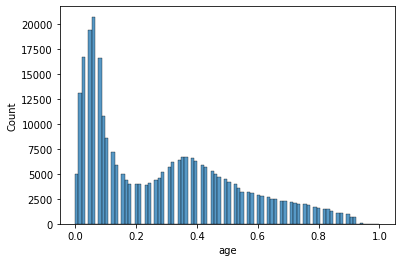

In [64]:
sns.histplot(df5['age'])

<AxesSubplot:xlabel='age', ylabel='Count'>

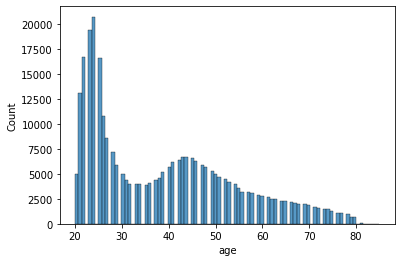

In [65]:
sns.histplot(aux)

In [66]:
# vintage
aux = df5['vintage']

mms_vintage = pp.MinMaxScaler()

df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

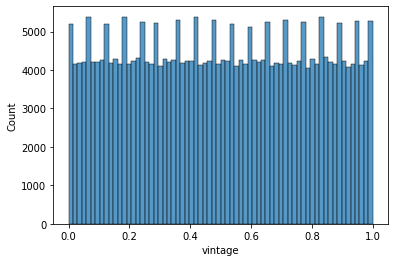

In [67]:
sns.histplot(df5['vintage'])

<AxesSubplot:xlabel='vintage', ylabel='Count'>

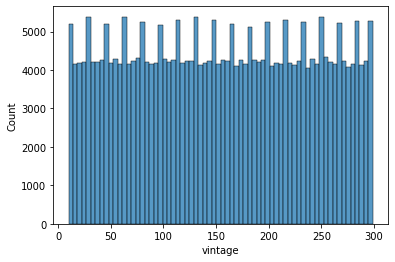

In [68]:
sns.histplot(aux)

## 5.3 Transformation

### 5.3.1 Encoding

In [69]:
# driving_license: its already a code (0 or 1 -> label encoding)
# previously_insured: its already a code (0 or 1 -> label encoding)
# vehicle_damage: its already a code (0 or 1 -> label encoding)

In [70]:
# gender - One hot encoding / **Target encoding**
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
#target_encode_gender
#df5['gender']

In [71]:
# region_code (it has so much levels) - **Target Encoding**/ Frequency Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
#target_encode_region_code
#df5['region_code']

In [72]:
# vehicle_age: if considered only two year as double of one year, cars that are 14 months old aren't doubly old than a car with 6 months (**One hot Encoding**/ Order Encoding/ Frequency Encoding)
df_aux = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
df5 = df_aux
#df_aux

In [73]:
# policy_sales_channel: Targer Enconding/ **Frequency Encoding**
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
#fe_policy_sales_channel
#df5['policy_sales_channel']

## 5.4 Preparation of Validation

In [74]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age (applying just transform metho, so it don't add new measures of mean an std values to the feature that are different of the training dataset)
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna -> if there is any value tha is on validation but is not in train dataset
x_validation = x_validation.fillna(0)

In [75]:
df5.to_csv('../data/interim/df5.csv', index=False)

# 6.0 Feature Selection

In [76]:
df6 = pd.read_csv('../data/interim/df5.csv')

## 6.1 Boruta Algorithm

## 6.2 Features Importance

In [77]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.274569
0                annual_premium    0.245075
0                           age    0.164615
0                   region_code    0.104127
0                vehicle_damage    0.066495
0          policy_sales_channel    0.058908
0            previously_insured    0.057681
0      vehicle_age_below_1_year    0.014120
0  vehicle_age_between_1_2_year    0.006812
0                        gender    0.004829
0      vehicle_age_over_2_years    0.002273
0               driving_license    0.000496


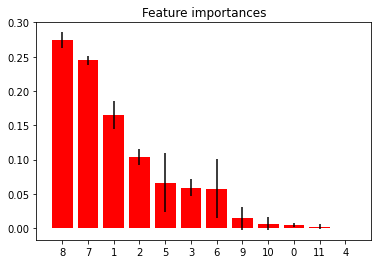

In [78]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [79]:
df6.to_csv('../data/interim/df6.csv', index=False)

# 7.0 Machine Learning

In [80]:
df7 = pd.read_csv('../data/interim/df6.csv')

In [81]:
cols_selected_importance = ['vintage', 'annual_premium', 'age', 'region_code', 'policy_sales_channel']

In [82]:
x_train = df7[cols_selected_importance]

x_val = x_validation[cols_selected_importance]
y_val = y_validation

## 7.1 KNN Classifier

In [83]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalization
yhat_knn = knn_model.predict_proba(x_val)

Because the problem is a ordened list we need some metrics of ordenation

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

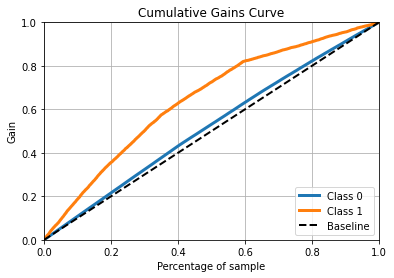

In [84]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

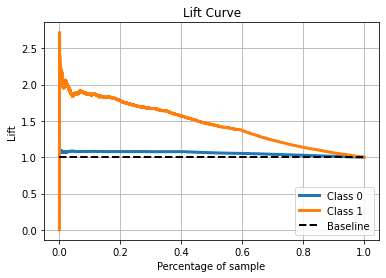

In [85]:
# says how much the prediction is better with the model im comparison with no model.
skplt.metrics.plot_lift_curve(y_val, yhat_knn)

## 7.2 Logistic Regresion

In [86]:
# model definition
lr_model = lm.LogisticRegression(random_state=60)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

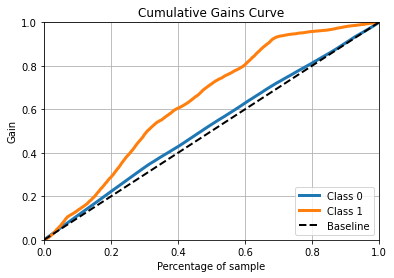

In [87]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

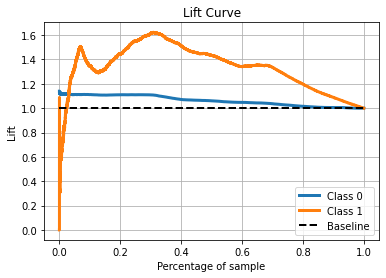

In [88]:
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 7.3 Extra Trees Classifier

In [89]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

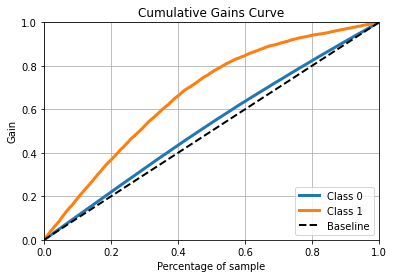

In [90]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

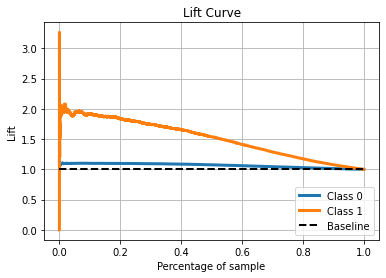

In [91]:
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 7.4 Random Forest

In [92]:
# model definition
rf = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train, y_train)

# model prediction
yhat_rf = et.predict_proba(x_val)

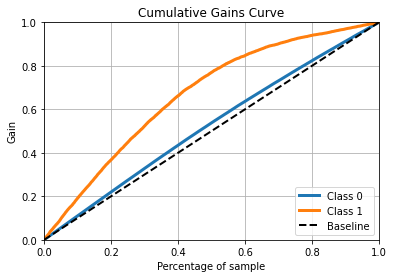

In [93]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

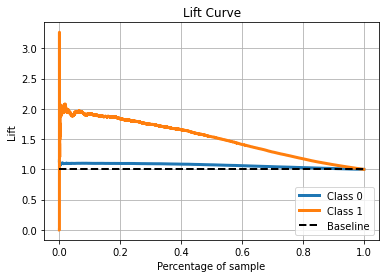

In [94]:
skplt.metrics.plot_lift_curve(y_val, yhat_rf);

# 8.0 Model Performance

In [95]:
df8 = x_validation.copy()

In [96]:
df8.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
37087,296282,0.137991,0.046154,0.044608,0.354312,1,0,1,-0.051035,0.692042,1,0,0
312182,208577,0.137991,0.184615,0.131560,0.209087,1,0,1,-0.273925,0.138408,1,0,0
300504,114846,0.104467,0.276923,0.186528,0.209087,1,0,1,-0.390187,0.972318,0,1,0
157359,113803,0.137991,0.061538,0.087674,0.354312,1,1,0,0.270936,0.446367,1,0,0
188248,361131,0.137991,0.215385,0.186528,0.209087,1,1,0,0.481288,0.923875,0,1,0


In [97]:
df8['response'] = y_validation.copy()

In [101]:
# propensity score (just to order the base, after this is useless)
df8['score'] = yhat_knn[:, 1].tolist()

In [103]:
# sort clients by propensity score
df8 = df8.sort_values('score', ascending=False)

In [104]:
df8

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response,score
54861,56740,0.104467,0.184615,0.186528,0.193960,1,1,0,0.391958,0.217993,1,0,0,0,0.9
14897,119845,0.104467,0.153846,0.075414,0.193960,1,0,1,-0.382874,0.681661,0,1,0,0,0.9
139251,350943,0.137991,0.200000,0.186528,0.027889,1,1,0,-1.621478,0.750865,0,1,0,0,0.8
124833,234263,0.137991,0.215385,0.070457,0.003100,1,1,0,-1.621478,0.114187,1,0,0,1,0.8
239033,4672,0.137991,0.153846,0.075414,0.027889,1,1,0,-1.621478,0.536332,1,0,0,0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28933,231036,0.104467,0.030769,0.125381,0.354312,1,0,1,0.659948,0.370242,1,0,0,0,0.0
161187,144274,0.137991,0.246154,0.095819,0.017629,1,0,1,-1.621478,0.107266,0,1,0,0,0.0
257443,151980,0.137991,0.215385,0.101812,0.354312,1,0,1,0.026802,0.878893,0,1,0,0,0.0
797,6493,0.137991,0.107692,0.186528,0.354312,1,1,1,0.912150,0.415225,1,0,0,0,0.0


In [109]:
## reset index
#df8 = df8.reset_index(drop = True)
#
## create ranking order
#df8['ranking'] = df8.index + 1
#
#df8['precision_at_k'] = df8['response'].cumsum() / df8['ranking']
#
#df8[['id', 'response', 'score', 'ranking', 'precision_at_k']]

def precision_at_k(data, k=10):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[ k, 'precision_at_k'], data)

In [112]:
def recall_at_k(data, k=15):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    # copu
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[ k, 'recall_at_k'], data)

In [113]:
# compute precision at k
precision_at_50 = precision_at_k(df8, k=50)
print(f'Precision at K:{precision_at_50}')

# compute recall at k
recall_at_50 = recall_at_k(df8, k=50)
print(f'Recall at K:{recall_at_50}')

Precision at K:(0.2549019607843137,            id    gender       age  region_code  policy_sales_channel  \
0       56740  0.104467  0.184615     0.186528              0.193960   
1      119845  0.104467  0.153846     0.075414              0.193960   
2      350943  0.137991  0.200000     0.186528              0.027889   
3      234263  0.137991  0.215385     0.070457              0.003100   
4        4672  0.137991  0.153846     0.075414              0.027889   
...       ...       ...       ...          ...                   ...   
76217  231036  0.104467  0.030769     0.125381              0.354312   
76218  144274  0.137991  0.246154     0.095819              0.017629   
76219  151980  0.137991  0.215385     0.101812              0.354312   
76220    6493  0.137991  0.107692     0.186528              0.354312   
76221   17757  0.137991  0.046154     0.070185              0.354312   

       driving_license  vehicle_damage  previously_insured  annual_premium  \
0                    

# 9